In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

from collections import OrderedDict

In [2]:
# Load dataset
train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [4]:
device = torch.device('mps')

In [5]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 100

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, _y) in enumerate(train_dataloader):
            X = X.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, torch.flatten(X, start_dim=1))
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss = 0
        model.eval()
        with torch.inference_mode():
            for X, _y in test_dataloader:
                X = X.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, torch.flatten(X, start_dim=1))

            test_loss /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

In [6]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
middle = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, middle),
    nn.ReLU(),
    nn.Linear(middle, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, inputs)
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.4)

In [63]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/100] Train loss: 0.06728 | Test loss: 0.06210
[EPOCH 2/100] Train loss: 0.05852 | Test loss: 0.05466
[EPOCH 3/100] Train loss: 0.04995 | Test loss: 0.04448
[EPOCH 4/100] Train loss: 0.04295 | Test loss: 0.04069
[EPOCH 5/100] Train loss: 0.03962 | Test loss: 0.03819
[EPOCH 6/100] Train loss: 0.03787 | Test loss: 0.03660
[EPOCH 7/100] Train loss: 0.03578 | Test loss: 0.03416
[EPOCH 8/100] Train loss: 0.03380 | Test loss: 0.03272
[EPOCH 9/100] Train loss: 0.03265 | Test loss: 0.03181
[EPOCH 10/100] Train loss: 0.03186 | Test loss: 0.03107
[EPOCH 11/100] Train loss: 0.03121 | Test loss: 0.03044
[EPOCH 12/100] Train loss: 0.03063 | Test loss: 0.02987
[EPOCH 13/100] Train loss: 0.03010 | Test loss: 0.02941
[EPOCH 14/100] Train loss: 0.02962 | Test loss: 0.02894
[EPOCH 15/100] Train loss: 0.02918 | Test loss: 0.02853
[EPOCH 16/100] Train loss: 0.02877 | Test loss: 0.02816
[EPOCH 17/100] Train loss: 0.02838 | Test loss: 0.02780
[EPOCH 18/100] Train loss: 0.02803 | Test loss: 0.02744
[

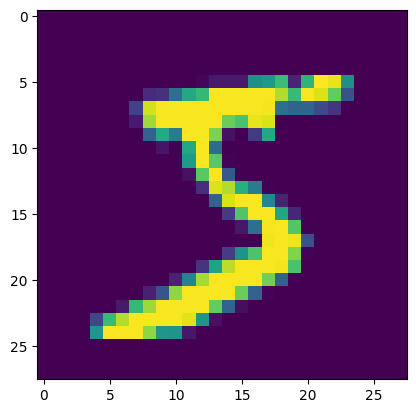

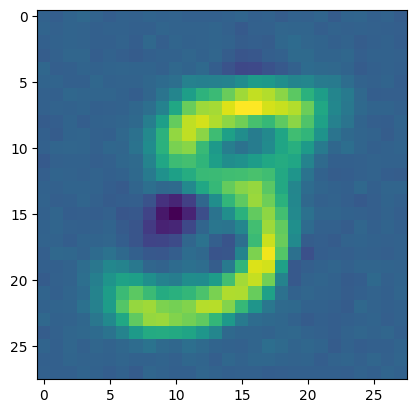

In [64]:
image, _ = train[0]
generated = model(image.to(device))
generated = generated.to('cpu').detach().reshape((28, 28))

plt.imshow(image.squeeze())
plt.show()
plt.imshow(generated)
plt.show()

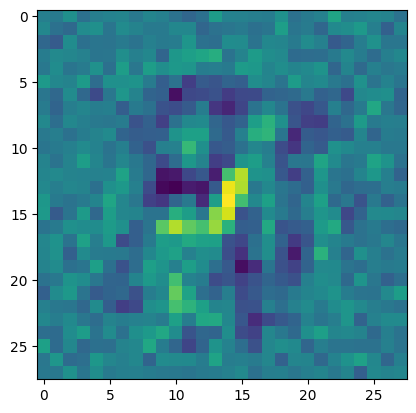

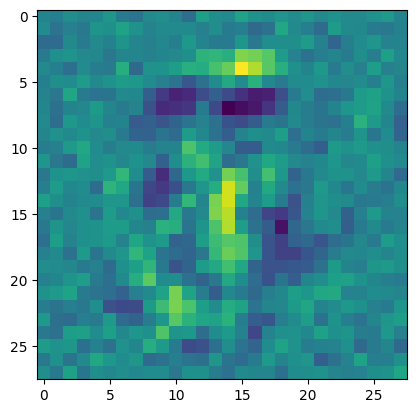

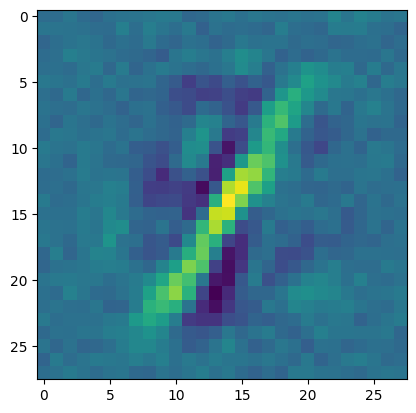

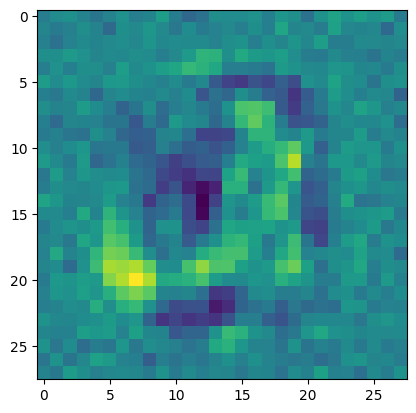

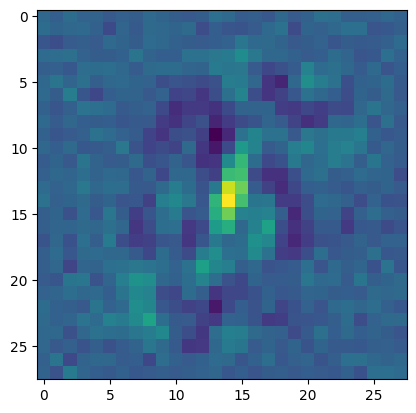

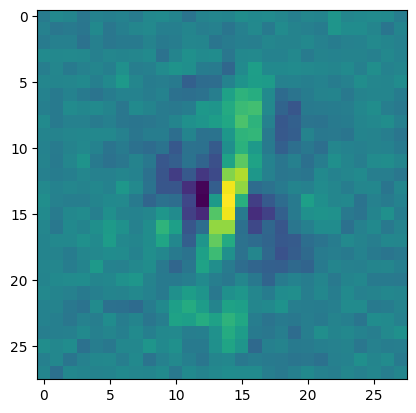

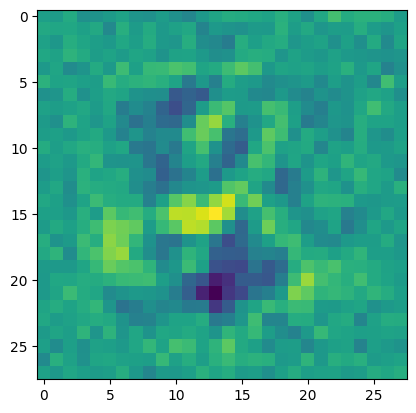

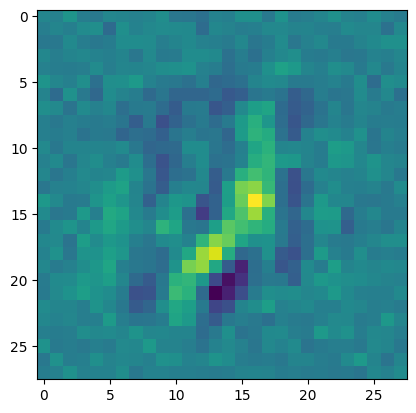

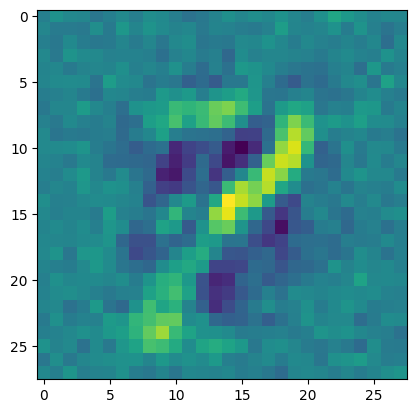

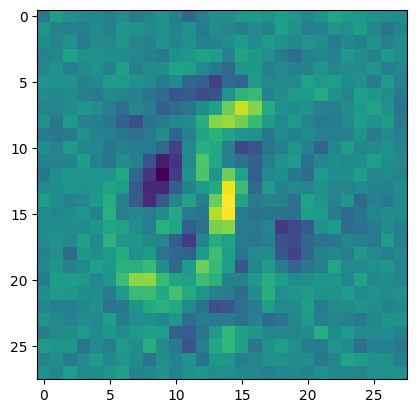

In [65]:
for digit in range(10):
    layers = []
    for l, layer in enumerate(model.children()):
        if l >= 7:
            layers.append(layer)

    generative_model = nn.Sequential(*layers)

    generated_image = generative_model(torch.tensor([0.] * digit + [1.] + [0.]*(9-digit)).to(device))
    generated_image = generated_image.to('cpu').detach().reshape((28, 28))

    plt.imshow(generated_image)
    plt.show()

### Decoder training

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [19]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=encoder.parameters(), lr=0.1)

In [20]:
torch.manual_seed(42)
epochs = 1

for epoch in range(epochs):
    print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        encoder.train()

        y_pred = encoder(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    encoder.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = encoder(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

[EPOCH 1/1] Train loss: 0.35896 | Test loss: 0.14943, Test acc: 95.41%


In [55]:
# Build the model
inputs = 10
hidden1 = 100
hidden2 = 300
outputs = 784

decoder = nn.Sequential(
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.3)

In [56]:
torch.manual_seed(42)
epochs = 5

for epoch in range(epochs):
    print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.reshape((BATCH_SIZE, 784)).to(device), torch.Tensor(np.array([torch.tensor([0.] * int(digit) + [1.] + [0.]*(9-int(digit))) for digit in y])).to(device)

        decoder.train()

        X_pred = decoder(y)

        loss = loss_fn(X_pred, X)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)

    test_loss = 0
    decoder.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.reshape((X.shape.numel()//784, 784)).to(device), torch.Tensor(np.array([torch.tensor([0.] * int(digit) + [1.] + [0.]*(9-int(digit))) for digit in y])).to(device)
            test_pred = decoder(y)

            test_loss += loss_fn(test_pred, X)

        test_loss /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

[EPOCH 1/5] Train loss: 0.06955 | Test loss: 0.06330
[EPOCH 2/5] Train loss: 0.06017 | Test loss: 0.05710
[EPOCH 3/5] Train loss: 0.05584 | Test loss: 0.05456
[EPOCH 4/5] Train loss: 0.05440 | Test loss: 0.05370
[EPOCH 5/5] Train loss: 0.05386 | Test loss: 0.05335


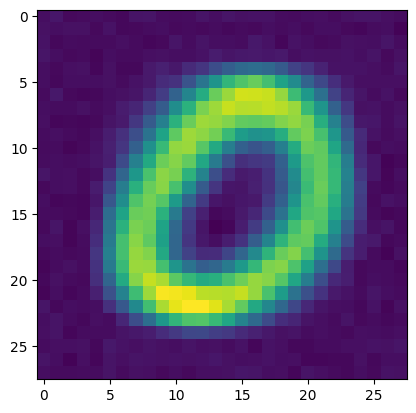

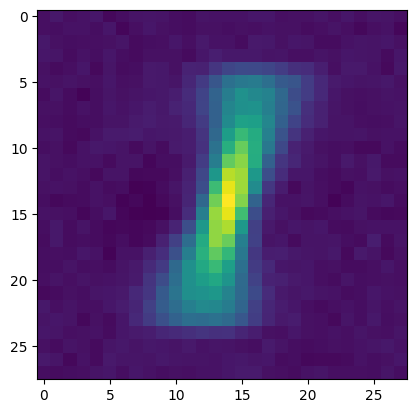

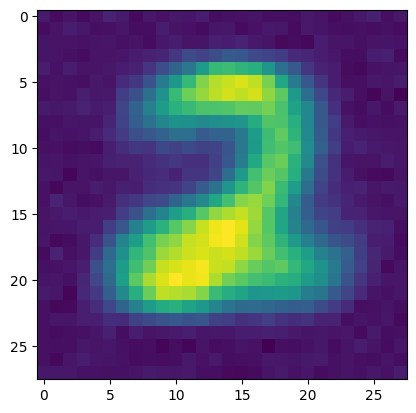

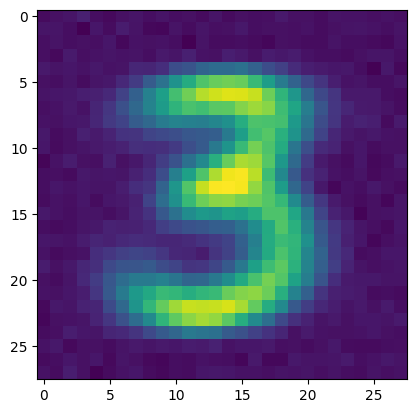

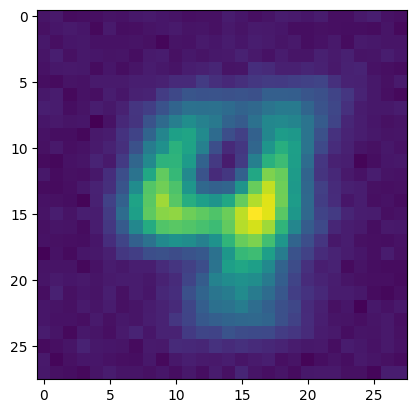

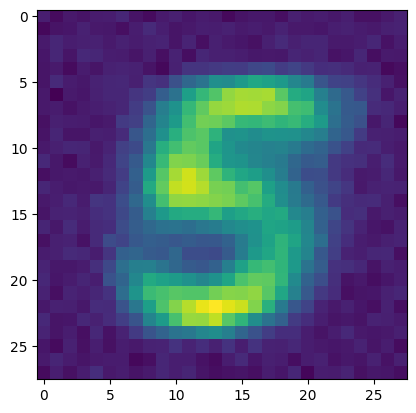

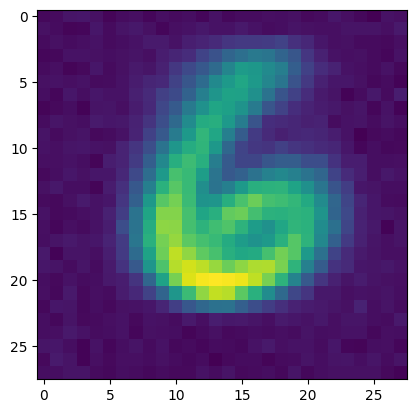

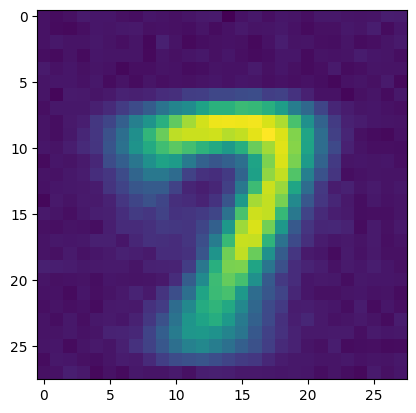

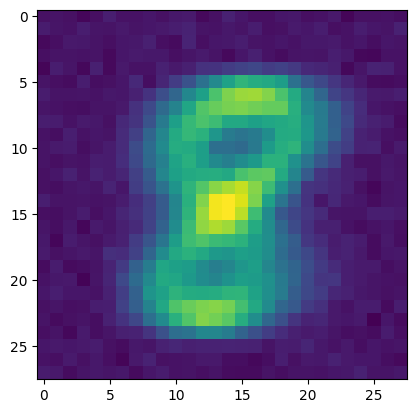

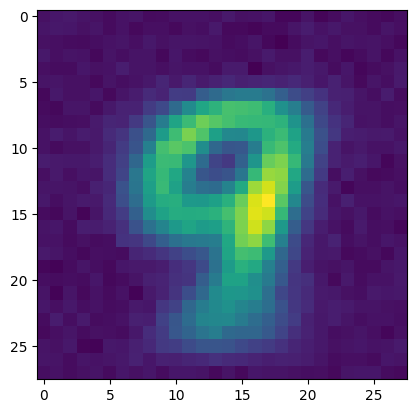

In [57]:
for digit in range(10):
    generated_image = decoder(torch.tensor([0.] * digit + [1.] + [0.]*(9-digit)).to(device))
    generated_image = generated_image.to('cpu').detach().reshape((28, 28))

    plt.imshow(generated_image)
    plt.show()